# Load libraries

In [2]:
!pip install plotly

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

# Load and Describe Data

In [29]:
df = pd.read_csv('transactions.csv')

In [30]:
df.head(5)

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   125000 non-null  object
 1   trans_date    125000 non-null  object
 2   trans_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [32]:
df.shape

(125000, 3)

# Check Missing & Null Data

In [33]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,customer_id,0
1,trans_date,0
2,trans_amount,0


In [34]:
df.duplicated().sum()

6

In [35]:
df=df.drop_duplicates()

In [36]:
df.duplicated().sum()

0

# Recency

In [39]:
df['trans_date'] = pd.to_datetime(df['trans_date'],errors='coerce')

In [41]:
df['trans_date'] = df['trans_date'].astype('datetime64[ns]')

In [42]:
print(df['trans_date'].min(), df['trans_date'].max())

2016-05-16 00:00:00 2020-03-16 00:00:00


In [43]:
last_date=df['trans_date'].max()
last_date

Timestamp('2020-03-16 00:00:00')

In [44]:
recency=df.groupby('customer_id').agg({'trans_date': 'max'}).reset_index()
recency.columns=['customer_id','last_trans']
recency['recency']=last_date-recency['last_trans']
recency=recency.drop(['last_trans'],axis=1)

recency['recency'] = pd.DataFrame(recency['recency'].astype('timedelta64[D]'))

recency

,customer_id,recency
0,CS1112,62.0
1,CS1113,36.0
2,CS1114,33.0
3,CS1115,11.0
4,CS1116,204.0
...,...,...
6884,CS8996,98.0
6885,CS8997,262.0
6886,CS8998,85.0
6887,CS8999,258.0


# Frequency

In [46]:
frequency=df.groupby('customer_id').agg({'trans_amount':'count'}).reset_index()
frequency.columns=['customer_id','frequency']
frequency

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


# Monetary

In [48]:
monetary=df.groupby('customer_id').agg({'trans_amount': 'sum'}).reset_index()
monetary.columns=['customer_id','monetary']
monetary

,customer_id,monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857
...,...,...
6884,CS8996,582
6885,CS8997,543
6886,CS8998,624
6887,CS8999,383


# RFM

In [49]:
RFM=recency.merge(frequency,
                 on='customer_id')
RFM=RFM.merge(monetary,
             on='customer_id')
RFM

,customer_id,recency,frequency,monetary
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,11.0,22,1659
4,CS1116,204.0,13,857
...,...,...,...,...
6884,CS8996,98.0,13,582
6885,CS8997,262.0,14,543
6886,CS8998,85.0,13,624
6887,CS8999,258.0,12,383


# Standarization

In [50]:
X=RFM[['recency','frequency','monetary']]

from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
RFM_std = pd.DataFrame(data = X_std, columns = ['recency','frequency','monetary'])
RFM_std.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,6.446352e-19,2.564053e-15,-9.564131e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.510168e-01,-2.723785e+00,-2.211731e+00
25%,-6.821344e-01,-7.980317e-01,-8.549248e-01
50%,-3.197276e-01,-2.773040e-02,1.025680e-01
75%,3.583238e-01,7.425709e-01,7.315936e-01
max,9.079468e+00,4.016351e+00,3.765085e+00


# K Means

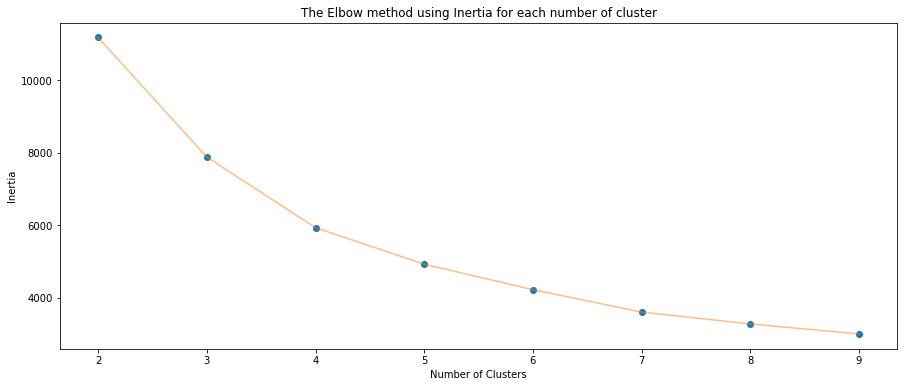

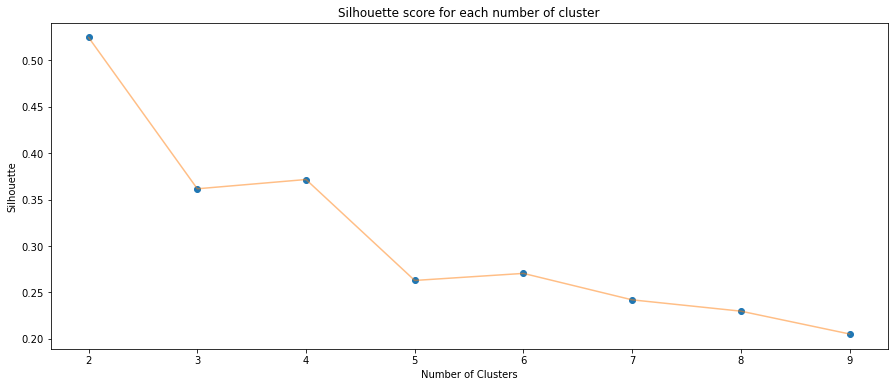

In [56]:
    k_max = 10
    inertia = []
    silhouette = []
    
    for k in range(2, k_max):
        km =  KMeans(init = 'k-means++', n_clusters = k, random_state= 49)
        km.fit(RFM_std.values)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()

from the test results above we will use k=4.

In [57]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=49)
kmeans.fit(RFM_std.values)

KMeans(n_clusters=4, random_state=49)

In [58]:
RFM_std['cluster']= kmeans.labels_

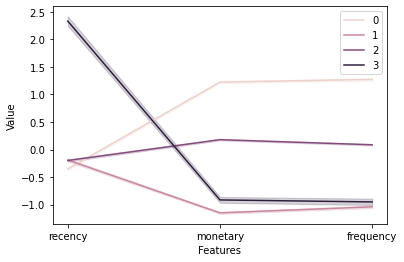

In [59]:
melted_RFM=pd.melt(RFM_std.reset_index(),
                  id_vars=['cluster'],
                   value_vars=['recency','monetary','frequency'],
                   var_name='Features',
                   value_name='Value'
                  )

sns.lineplot('Features','Value',hue='cluster',data=melted_RFM)
plt.legend()

In [60]:
fig = px.scatter_3d(RFM_std, x='recency', y='monetary', z='frequency', color='cluster',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

# Clustering Analysis

Loyal customers have low recency values and high frequency and monetary values, while regular customers have high recency values and lower frequency and monetary values. It can be seen in the recency,frequency, and monetary diagram that the order of customers from most loyal to regular customers is cluster 0, 2, 1, 3.

Then we label it

    - High Loyalty (cluster 0)
    - Medium Loyalty (cluster 2)
    - Low Loyalty (cluster 1)
    - No Loyalty (cluster 3)

In [84]:
RFM['Cluster']=RFM_std['cluster']

In [85]:
RFM.head()

,customer_id,recency,frequency,monetary,Cluster
0,CS1112,62.0,15,1012,2
1,CS1113,36.0,20,1490,2
2,CS1114,33.0,19,1432,2
3,CS1115,11.0,22,1659,0
4,CS1116,204.0,13,857,3


In [88]:
RFM.replace([0,1,2,3],['High Loyalty','Low Loyalty','Medium Loyalty','No Loyalty'])

,customer_id,recency,frequency,monetary,Cluster
0,CS1112,62.0,15,1012,Medium Loyalty
1,CS1113,36.0,20,1490,Medium Loyalty
2,CS1114,33.0,19,1432,Medium Loyalty
3,CS1115,11.0,22,1659,High Loyalty
4,CS1116,204.0,13,857,No Loyalty
...,...,...,...,...,...
6884,CS8996,98.0,13,582,Low Loyalty
6885,CS8997,262.0,14,543,No Loyalty
6886,CS8998,85.0,13,624,Low Loyalty
6887,CS8999,258.0,12,383,No Loyalty
